In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
import sys
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks')

In [4]:
import pytorch_optimizer as optim

In [5]:
import torch
import random
import numpy as np
import pandas as pd

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [6]:
import torchvision.datasets
from tqdm import tqdm
import pandas as pd

In [7]:
CIFAR_train = torchvision.datasets.CIFAR100('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR100('./', download=True, train=False)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


In [8]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [ ]:
len(y_train), len(y_test)

(50000, 10000)

In [ ]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [9]:
X_train /= 255.
X_test /= 255.

In [ ]:
CIFAR_train.classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

tensor(19) tensor(29) tensor(0) tensor(11) tensor(1) tensor(86) tensor(90) tensor(28) tensor(23) tensor(31) 

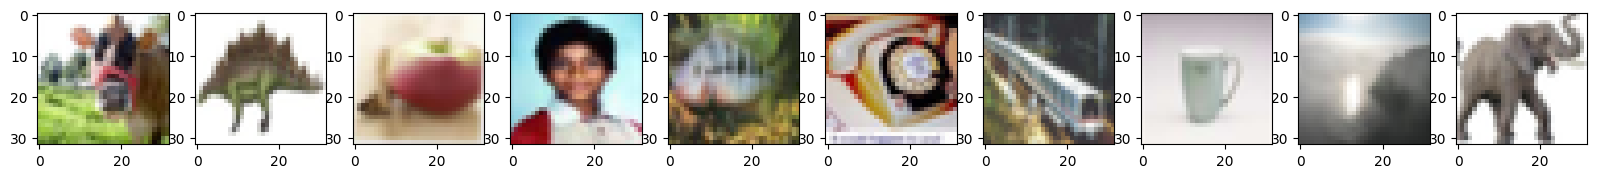

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [ ]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [11]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [11]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [12]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(net.parameters(), lr=5.0e-2)
    #optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-4)
    #optimizer = optim.PNMBelief(net.parameters(), lr=0.001)
    #optimizer = optim.YogiPNM(net.parameters())
    optimizer = optim.AdaBelief(net.parameters())
    #optimizer = optim.DiffGrad(net.parameters())
    #optimizer = optim.Yogi(net.parameters())
    
    batch_size = 200

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(20):
        print("epoch ", epoch)
        order = np.random.permutation(len(X_train))
        
        if epoch == 12:
            #optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-5)
            #optimizer = optim.PNMBelief(net.parameters(), lr=1.0e-4)
            #optimizer = optim.YogiPNM(net.parameters(), lr=1.0e-4)
            optimizer = optim.AdaBelief(net.parameters(), lr=1.0e-4)
            #optimizer = optim.DiffGrad(net.parameters(), lr=1.0e-4)
            #optimizer = optim.Yogi(net.parameters(), lr=1.0e-4)
    

        for start_index in tqdm(range(0, len(X_train), batch_size)):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            loss_value = loss(test_preds, y_test).item()
            test_loss_history.append(loss_value)

            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
            test_accuracy_history.append(accuracy)
            #print(test_preds.argmax(dim=1))
            #print(y_test)

        print("accuracy = ", accuracy)
        print("\n\n")

    return test_accuracy_history, test_loss_history

In [13]:
accuracies = {}
losses = {}

In [14]:
from torchvision.models import vgg16, VGG16_Weights

In [ ]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
accuracies['vgg16+Adam'], losses['vgg16+Adam'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:49<00:00,  5.06it/s]


accuracy =  0.3977999985218048



epoch  1


100%|██████████| 250/250 [00:48<00:00,  5.11it/s]


accuracy =  0.5164999961853027



epoch  2


100%|██████████| 250/250 [00:49<00:00,  5.07it/s]


accuracy =  0.5636000037193298



epoch  3


100%|██████████| 250/250 [00:49<00:00,  5.09it/s]


accuracy =  0.5794000029563904



epoch  4


100%|██████████| 250/250 [00:49<00:00,  5.07it/s]


accuracy =  0.590499997138977



epoch  5


100%|██████████| 250/250 [00:49<00:00,  5.08it/s]


accuracy =  0.5971999764442444



epoch  6


100%|██████████| 250/250 [00:49<00:00,  5.08it/s]


accuracy =  0.5952999591827393



epoch  7


100%|██████████| 250/250 [00:49<00:00,  5.08it/s]


accuracy =  0.5986999869346619



epoch  8


100%|██████████| 250/250 [00:49<00:00,  5.07it/s]


accuracy =  0.6040999889373779



epoch  9


100%|██████████| 250/250 [00:49<00:00,  5.06it/s]


accuracy =  0.6078999638557434



epoch  10


100%|██████████| 250/250 [00:49<00:00,  5.07it/s]


accuracy =  0.604200005531311



epoch  11


100%|██████████| 250/250 [00:49<00:00,  5.08it/s]


accuracy =  0.6033999919891357



epoch  12


100%|██████████| 250/250 [00:49<00:00,  5.08it/s]


accuracy =  0.6306999921798706



epoch  13


100%|██████████| 250/250 [00:49<00:00,  5.07it/s]


accuracy =  0.6322000026702881



epoch  14


100%|██████████| 250/250 [00:49<00:00,  5.07it/s]


accuracy =  0.6323999762535095



epoch  15


 10%|▉         | 24/250 [00:04<00:44,  5.05it/s]


KeyboardInterrupt: ignored

In [ ]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
accuracies['vgg16+PNMBelief'], losses['vgg16+PNMBelief'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


accuracy =  0.020800000056624413



epoch  1


100%|██████████| 250/250 [00:57<00:00,  4.34it/s]


accuracy =  0.04050000011920929



epoch  2


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


accuracy =  0.07369999587535858



epoch  3


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


accuracy =  0.0997999981045723



epoch  4


100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


accuracy =  0.19679999351501465



epoch  5


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


accuracy =  0.2240999937057495



epoch  6


100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


accuracy =  0.29829999804496765



epoch  7


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


accuracy =  0.3360999822616577



epoch  8


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


accuracy =  0.3797999918460846



epoch  9


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


accuracy =  0.41040000319480896



epoch  10


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


accuracy =  0.43609997630119324



epoch  11


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


accuracy =  0.45479997992515564



epoch  12


100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


accuracy =  0.5336999893188477



epoch  13


100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


accuracy =  0.5390999913215637



epoch  14


100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


accuracy =  0.5446999669075012



epoch  15


100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


accuracy =  0.5489999651908875



epoch  16


100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


accuracy =  0.5490999817848206



epoch  17


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


accuracy =  0.5507000088691711



epoch  18


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


accuracy =  0.5507000088691711



epoch  19


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


accuracy =  0.5551999807357788





In [ ]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
accuracies['vgg16+Yogi'], losses['vgg16+Yogi'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:51<00:00,  4.87it/s]


accuracy =  0.3893999755382538



epoch  1


100%|██████████| 250/250 [00:50<00:00,  4.91it/s]


accuracy =  0.46309998631477356



epoch  2


100%|██████████| 250/250 [00:51<00:00,  4.89it/s]


accuracy =  0.527999997138977



epoch  3


100%|██████████| 250/250 [00:50<00:00,  4.92it/s]


accuracy =  0.5627999901771545



epoch  4


100%|██████████| 250/250 [00:50<00:00,  4.91it/s]


accuracy =  0.5412999987602234



epoch  5


100%|██████████| 250/250 [00:50<00:00,  4.92it/s]


accuracy =  0.5537999868392944



epoch  6


100%|██████████| 250/250 [00:50<00:00,  4.93it/s]


accuracy =  0.5566999912261963



epoch  7


100%|██████████| 250/250 [00:50<00:00,  4.92it/s]


accuracy =  0.5655999779701233



epoch  8


100%|██████████| 250/250 [00:50<00:00,  4.93it/s]


accuracy =  0.5810999870300293



epoch  9


100%|██████████| 250/250 [00:50<00:00,  4.93it/s]


accuracy =  0.5834000110626221



epoch  10


100%|██████████| 250/250 [00:50<00:00,  4.93it/s]


accuracy =  0.5794000029563904



epoch  11


100%|██████████| 250/250 [00:50<00:00,  4.94it/s]


accuracy =  0.5751000046730042



epoch  12


100%|██████████| 250/250 [00:50<00:00,  4.95it/s]


accuracy =  0.6279999613761902



epoch  13


100%|██████████| 250/250 [00:50<00:00,  4.95it/s]


accuracy =  0.6376999616622925



epoch  14


100%|██████████| 250/250 [00:50<00:00,  4.94it/s]


accuracy =  0.6378999948501587



epoch  15


  9%|▉         | 23/250 [00:04<00:46,  4.90it/s]


KeyboardInterrupt: ignored

In [ ]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
accuracies['vgg16+DiffGrad'], losses['vgg16+DiffGrad'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


accuracy =  0.10939999669790268



epoch  1


100%|██████████| 250/250 [00:57<00:00,  4.38it/s]


accuracy =  0.29499998688697815



epoch  2


100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


accuracy =  0.38599997758865356



epoch  3


100%|██████████| 250/250 [00:58<00:00,  4.31it/s]


accuracy =  0.4412999749183655



epoch  4


100%|██████████| 250/250 [00:58<00:00,  4.29it/s]


accuracy =  0.484499990940094



epoch  5


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


accuracy =  0.5026000142097473



epoch  6


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


accuracy =  0.5196999907493591



epoch  7


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


accuracy =  0.5489999651908875



epoch  8


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


accuracy =  0.542199969291687



epoch  9


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


accuracy =  0.5503999590873718



epoch  10


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


accuracy =  0.5514000058174133



epoch  11


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


accuracy =  0.5533999800682068



epoch  12


100%|██████████| 250/250 [00:58<00:00,  4.29it/s]


accuracy =  0.5964999794960022



epoch  13


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


accuracy =  0.602400004863739



epoch  14


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


accuracy =  0.6033999919891357



epoch  15


 21%|██        | 52/250 [00:12<00:46,  4.26it/s]


KeyboardInterrupt: ignored

In [ ]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
accuracies['vgg16+YogiPNM'], losses['vgg16+YogiPNM'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:56<00:00,  4.43it/s]


accuracy =  0.03500000014901161



epoch  1


100%|██████████| 250/250 [00:57<00:00,  4.35it/s]


accuracy =  0.1013999953866005



epoch  2


100%|██████████| 250/250 [00:57<00:00,  4.32it/s]


accuracy =  0.18060000240802765



epoch  3


100%|██████████| 250/250 [00:58<00:00,  4.29it/s]


accuracy =  0.26829999685287476



epoch  4


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


accuracy =  0.35909998416900635



epoch  5


100%|██████████| 250/250 [00:58<00:00,  4.27it/s]


accuracy =  0.44029998779296875



epoch  6


100%|██████████| 250/250 [00:58<00:00,  4.27it/s]


accuracy =  0.4902999997138977



epoch  7


100%|██████████| 250/250 [00:58<00:00,  4.27it/s]


accuracy =  0.49570000171661377



epoch  8


100%|██████████| 250/250 [00:58<00:00,  4.27it/s]


accuracy =  0.523099958896637



epoch  9


100%|██████████| 250/250 [00:58<00:00,  4.26it/s]


accuracy =  0.5530999898910522



epoch  10


100%|██████████| 250/250 [00:58<00:00,  4.27it/s]


accuracy =  0.5482999682426453



epoch  11


100%|██████████| 250/250 [00:58<00:00,  4.27it/s]


accuracy =  0.5598999857902527



epoch  12


100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


accuracy =  0.6069999933242798



epoch  13


100%|██████████| 250/250 [00:58<00:00,  4.27it/s]


accuracy =  0.6067000031471252



epoch  14


100%|██████████| 250/250 [00:58<00:00,  4.27it/s]


accuracy =  0.6062999963760376



epoch  15


 44%|████▍     | 110/250 [00:25<00:32,  4.25it/s]


KeyboardInterrupt: ignored

In [15]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
accuracies['vgg16+AdaBelief'], losses['vgg16+AdaBelief'] = \
    train(model, X_train, y_train, X_test, y_test)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

epoch  0


100%|██████████| 250/250 [00:59<00:00,  4.22it/s]


accuracy =  0.3732999861240387



epoch  1


100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


accuracy =  0.48479998111724854



epoch  2


100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


accuracy =  0.5020999908447266



epoch  3


100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


accuracy =  0.5318999886512756



epoch  4


100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


accuracy =  0.5479999780654907



epoch  5


100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


accuracy =  0.5259999632835388



epoch  6


100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


accuracy =  0.5360999703407288



epoch  7


100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


accuracy =  0.552299976348877



epoch  8


100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


accuracy =  0.5411999821662903



epoch  9


100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


accuracy =  0.5246999859809875



epoch  10


100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


accuracy =  0.51419997215271



epoch  11


100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


accuracy =  0.5310999751091003



epoch  12


100%|██████████| 250/250 [00:54<00:00,  4.60it/s]


accuracy =  0.5999999642372131



epoch  13


100%|██████████| 250/250 [00:54<00:00,  4.59it/s]


accuracy =  0.6114000082015991



epoch  14


100%|██████████| 250/250 [00:54<00:00,  4.59it/s]


accuracy =  0.6164000034332275



epoch  15


100%|██████████| 250/250 [00:54<00:00,  4.59it/s]


accuracy =  0.6187999844551086



epoch  16


100%|██████████| 250/250 [00:54<00:00,  4.59it/s]


accuracy =  0.6207999587059021



epoch  17


100%|██████████| 250/250 [00:54<00:00,  4.59it/s]


accuracy =  0.6141999959945679



epoch  18


  8%|▊         | 20/250 [00:04<00:50,  4.56it/s]


KeyboardInterrupt: ignored

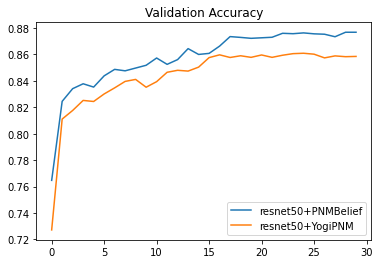

In [ ]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

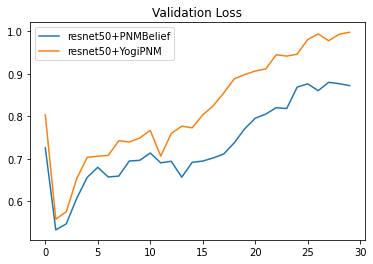

In [ ]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

In [ ]:
data = np.zeros((10,10), dtype=int)
D = pd.DataFrame(data)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
test_preds = model.forward(X_test)

In [ ]:
for x, y in zip(test_preds.argmax(dim=1).tolist(), y_test.tolist()):
    D[y][x] += 1

In [ ]:
D # resnet18+PNMBelief

,0,1,2,3,4,5,6,7,8,9
0,879,12,42,15,14,12,8,11,34,19
1,12,906,5,8,2,1,4,2,16,43
2,24,6,793,55,35,39,27,11,7,4
3,14,3,23,635,35,103,19,21,8,6
4,9,0,47,53,838,30,34,28,1,2
5,1,2,28,151,20,753,12,29,2,2
6,3,5,33,39,12,15,888,3,3,3
7,14,3,20,26,30,34,3,882,1,7
8,29,10,5,9,11,4,3,4,917,13
9,15,53,4,9,3,9,2,9,11,901


In [ ]:
D # resnet18

,0,1,2,3,4,5,6,7,8,9
0,878,16,36,22,4,8,8,5,33,15
1,10,905,1,6,1,2,3,3,11,45
2,20,0,817,43,37,32,27,16,11,8
3,9,5,32,693,45,138,49,32,7,8
4,9,1,40,44,822,27,28,18,1,3
5,9,5,33,124,32,746,11,48,3,1
6,4,4,22,27,21,10,867,4,3,3
7,7,1,14,26,30,30,2,861,1,6
8,36,18,3,7,6,3,3,4,916,28
9,18,45,2,8,2,4,2,9,14,883


In [ ]:
APreds = pd.DataFrame()

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
test_preds = []
model.eval()
with torch.no_grad():
            test_preds = model.forward(X_test)

In [ ]:
APreds['Adam'] = test_preds.argmax(dim=1).tolist()

In [ ]:
APreds['PNMBelief'] = test_preds.argmax(dim=1).tolist()

In [ ]:
APreds['Yogi'] = test_preds.argmax(dim=1).tolist()

In [ ]:
APreds['DiffGrad'] = test_preds.argmax(dim=1).tolist()

In [ ]:
APreds['YogiPNM'] = test_preds.argmax(dim=1).tolist()

In [20]:
APreds['AdaBelief'] = test_preds.argmax(dim=1).tolist()

In [21]:
APreds

,Adam,PNMBelief,Yogi,DiffGrad,YogiPNM,AdaBelief
0,24,90,12,68,90,90
1,33,33,33,33,33,33
2,55,97,93,55,55,72
3,51,51,51,51,51,51
4,71,71,71,71,71,71
...,...,...,...,...,...,...
9995,83,83,83,83,0,0
9996,14,77,14,74,14,14
9997,51,51,51,51,51,51
9998,42,45,42,88,42,33


In [17]:
APreds = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ansambl_vgg16_100.csv')

In [18]:
APreds = APreds.drop(['Unnamed: 0'], axis=1)

In [ ]:
APreds.to_csv('/content/gdrive/MyDrive/Colab Notebooks/ansambl_vgg16_100.csv')

In [ ]:
APreds

,Adam,PNMBelief,Yogi,DiffGrad,YogiPNM
0,24,90,12,68,90
1,33,33,33,33,33
2,55,97,93,55,55
3,51,51,51,51,51
4,71,71,71,71,71
...,...,...,...,...,...
9995,83,83,83,83,0
9996,14,77,14,74,14
9997,51,51,51,51,51
9998,42,45,42,88,42


In [34]:
data = np.zeros((10000,100), dtype=int)
ARes = pd.DataFrame(data)

In [35]:
for i in range(10000):
    for j in range(6):
        if j == 0:
            ARes.iloc[i, APreds.iloc[i, j]] += 0.6373
        if j == 1:
            ARes.iloc[i, APreds.iloc[i, j]] += 0.5552
        if j == 2:
            ARes.iloc[i, APreds.iloc[i, j]] += 0.6379
        if j == 3:
            ARes.iloc[i, APreds.iloc[i, j]] += 0.6034
        if j == 4:
            ARes.iloc[i, APreds.iloc[i, j]] += 0.6063
        if j == 5:
            ARes.iloc[i, APreds.iloc[i, j]] += 0.6142

In [36]:
anslist = ARes.idxmax(axis=1)

In [37]:
accuracy = (torch.tensor(anslist).to(device) == y_test).float().mean().item()

In [38]:
accuracy

0.687999963760376